<a href="https://colab.research.google.com/github/carresl/trade-ratings/blob/main/Trading_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [1]:
!pip install ta

In [2]:
!pip install --upgrade yfinance

In [3]:
from google.colab import auth
from google.colab import files
import yfinance as yf
import pandas as pd
from pathlib import Path
import datetime
import pytz
from dateutil.relativedelta import relativedelta
import numpy as np
from ta.momentum import StochRSIIndicator as stoch_rsi
from ta.momentum import RSIIndicator as rsi
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
from scipy import stats
# tf libraries
from tensorflow.keras.layers import Dense, Concatenate, LSTM, Input, Embedding, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.losses import mean_squared_error as mse

# Parameters

### Ticker list

In [4]:
# 1) Choose which ticker file to read
ticker_file = 'NASDAQ100_2024.csv'
# 2) Choose which ticker list to use
ticker_list = 'Holding Ticker'

### Simulation parameters

In [5]:
# 1) Choose the length of the move which we want to predict (in trading days)
resp_length = 45
# 2) Choose the first date of the simulation
sim_start = datetime.date(2024, 1, 1)
# 3) Set the number of epochs
epochs = 200
# 4) Set the batch size
batches = 64
# 5) Set the regularization lambda value
reg = 0.00005
# 6) Set the patience for Early Stopping
patience = 5
# 7) Choose how often you want the model to be retrained in the simulation (in
#    number of resp_length periods), set to 0 to only train once
retrain_frequency = resp_length * 999999
# 8) Set the starting capital for the simulaiton
nav = 1_000_000
# 9) Specify the risk free asset
risk_free_asset = 'SPY'
# 10) Specify the number of simulations to run
num_sims = 10
# 11) Rating cutoff (min rating needed)
SR = 1
# 12) Long short or long only
long_short = False
# 13) Choose number of daily candles
num_day_candles = 200

## Data

### Get ticker list from GCloud

In [6]:
# authenticate user
auth.authenticate_user()

# command to copy the data from GCloud
!gsutil -m rsync -r gs://first-aaai-data-bucket/V2_ticker_lists/ /content/

# list of tickers
ai90 = list(set(list(pd.read_csv(ticker_file)[ticker_list])))
ai90 = [a for a in ai90 if isinstance(a, str)]


both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...


### Get the chart data from YFinance



In [7]:
# output the ticker list
print('Tickers being traded:')
print('')
for i, ticker in enumerate(ai90):
    print(f'{i+1}. {ticker}')

Tickers being traded:

1. TEAM 
2. CTSH 
3. INTC 
4. GOOG 
5. CCEP 
6. COST 
7. KLAC 
8. VRSK 
9. AMAT 
10. ZS 
11. PANW 
12. ON 
13. MELI 
14. WDAY 
15. AMZN 
16. VRTX 
17. EA 
18. MDB 
19. QCOM 
20. ODFL 
21. ILMN 
22. SBUX 
23. KHC 
24. CSGP 
25. LIN 
26. CEG 
27. MAR 
28. EXC 
29. SNPS 
30. FTNT 
31. AZN 
32. MU 
33. PAYX 
34. GFS 
35. ROP 
36. MNST 
37. PYPL 
38. ARM 
39. ASML 
40. ADI 
41. AMD 
42. AAPL 
43. SMCI 
44. DXCM 
45. ISRG 
46. TTD 
47. CSCO 
48. NXPI 
49. LRCX 
50. ADP 
51. IDXX 
52. ADBE 
53. HON 
54. MSFT 
55. ROST 
56. CSX 
57. INTU 
58. TMUS 
59. BKNG 
60. BKR 
61. TXN 
62. MRVL 
63. ANSS 
64. DDOG 
65. DASH 
66. AVGO 
67. ADSK 
68. CDW 
69. CDNS 
70. GILD 
71. META 
72. TSLA 
73. ABNB 
74. WBD 
75. NVDA 
76. APP 
77. CPRT 
78. CHTR 
79. FAST 
80. AEP 
81. FANG 
82. MDLZ 
83. PDD 
84. XEL 
85. LULU 
86. CRWD 
87. GEHC 
88. NFLX 
89. BIIB 
90. CTAS 
91. REGN 
92. AMGN 
93. ORLY 
94. MCHP 
95. PEP 
96. MRNA 
97. TTWO 
98. CMCSA 
99. PCAR 
100. KDP 


In [8]:
# download day, week, and month charts
day_charts = [yf.download(ticker, period = 'max', interval = '1d') for ticker in ai90]

# drop the multi-level
for d in day_charts:
    d['symbol'] = d.columns.get_level_values(1)[0]
    d.columns = d.columns.droplevel(1)

# reset index to get Date column
day_charts = [d.reset_index() for d in day_charts]

/tmp/ipython-input-8-2556899330.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  day_charts = [yf.download(ticker, period = 'max', interval = '1d') for ticker in ai90]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-8-2556899330.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  day_charts = [yf.download(ticker, period = 'max', interval = '1d') for ticker in ai90]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-8-2556899330.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  day_charts = [yf.download(ticker, period = 'max', interval = '1d') for ticker in ai90]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-8-2556899330.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  day_charts = [yf.download(ticker, period = 'max', interval =

### Function to preprocess data

In [9]:
def train_daily(data, length, resp_length, first_date=pd.to_datetime('2017-01-01')):
    '''
    Training data for daily candles

    Params:
        1. data: list of daily charts
        2. length: number of daily candles in each time series
        3. resp_length: number of days to hold each position
        4. first_date: cutoff date for the training data
    '''

    # 0) get the final data after cutoff date and get y variable
    data = [d[(d['Date'].dt.date >= first_date.date())] for i, d in enumerate(data)]
    for i, d in enumerate(data):
        dc = d.copy()
        dc['price_final'] = dc['Open'].shift(-(resp_length+1))
        dc['price_initial'] = dc['Open'].shift(-1)
        dc = dc[dc['price_final'] > 0]
        dc['Change'] = (dc['price_final'] - dc['price_initial']) / dc['price_initial']
        dc = dc.drop(columns=['price_final', 'price_initial'])
        data[i] = dc
    total_obs = sum([len(d)-length+1 for d in data])
    # 1) get the month_change, date and ticker information for each day of each ticker
    dates = np.zeros(total_obs, dtype=object)
    resp = np.zeros(total_obs)
    tickers = np.zeros(total_obs)
    ci = 0
    for i, d in enumerate(data):
        dates_vec = d['Date'].dt.date.values
        resp_vec = d['Change'].values
        tickers_vec = d['symbol'].values
        tickers_vec = np.ones(shape=tickers_vec.shape)*i
        fdv = dates_vec[length-1:]
        frv = resp_vec[length-1:]
        ftv = tickers_vec[length-1:]
        dates[ci:ci+fdv.shape[0]] = fdv
        resp[ci:ci+frv.shape[0]] = frv
        tickers[ci:ci+ftv.shape[0]] = ftv
        ci += fdv.shape[0]
    dates = dates.reshape((-1,1))
    resp = resp.reshape((-1,1))
    tickers = tickers.reshape((-1,1))
    # 2) put the data into SWV & normalize (the -3 here is for the 3 cols that we drop)
    data_swv = np.zeros((total_obs, length, len(data[0].columns)-3))
    # track the total number of entries
    si = 0
    # standard scaler
    scaler = StandardScaler()
    for k, d in enumerate(data):
        d_numerical = d.drop(['Date', 'symbol', 'Change'], axis=1)
        dnp = d_numerical.values
        dnp = sliding_window_view(dnp, window_shape=length, axis=0)
        dnp_fin = np.moveaxis(dnp, 2,1)
        # normalize each 30 day window independently
        for i in range(dnp_fin.shape[0]):
            # separate the price columns
            d_price = dnp_fin[i,:,:4]
            # the volume column
            d_vol = dnp_fin[i,:,4]
            d_ema = dnp_fin[i,:,5:]
            # normalize the volume
            d_vol = scaler.fit_transform(d_vol.reshape(-1,1))
            d_vol = d_vol.reshape(-1)
            d_price = scaler.fit_transform(d_price.reshape(-1,1))
            d_price = d_price.reshape((-1,4))
            data_swv[si,:,:4] = d_price
            data_swv[si,:,4] = d_vol
            data_swv[si,:,5:] = d_ema
            si += 1
    return data_swv, resp, dates, tickers

### Getting the final data

In [10]:
# final chart data
X, y, dates, tickers = train_daily(day_charts, num_day_candles, resp_length)

In [11]:
# verify the shapes are correct
print(X.shape, y.shape, dates.shape, tickers.shape)

(178187, 200, 5) (178187, 1) (178187, 1) (178187, 1)


## Simulation Functions

### Model Architecture

In [12]:
def define_model(daily_candles, daily_features, num_tickers, regularization):
    '''
    Defines the neural network model that will be used to make predictions

    Params:
        1. daily_candles: number of daily candles in each observation
        2. daily_features: number of features per candle (includes EMAs)
        3. num_tickers: number of tickers in the data set
        4. regularization: lambda value for regularization
    '''

    # input layer
    day_input = Input(shape=(daily_candles, daily_features), name='Daily Charts')
    # LSTM layers
    lo1 = LSTM(units=64,
               return_sequences=True,
               kernel_regularizer=l2(regularization),
               recurrent_regularizer=l2(regularization)
               )(day_input)
    ls1 = LSTM(units=32,
              return_sequences=False,
              kernel_regularizer=l2(regularization),
              recurrent_regularizer=l2(regularization)
              )(lo1)
    # hidden layers
    initializer = HeNormal()
    hidden1 = Dense(units=64,
                    kernel_initializer=initializer,
                    kernel_regularizer=l2(regularization),
                    activation='leaky_relu')(ls1)
    hidden2 = Dense(units=32,
                    kernel_initializer=initializer,
                    kernel_regularizer=l2(regularization),
                    activation='leaky_relu')(hidden1)
    # output layer
    output = Dense(1,name='Output')(hidden2)
    # define the model & compile
    model = Model(inputs=day_input, outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

### Function to get market return

In [13]:
def get_risk_free(rfa, resp_length, di, df):
    '''
    Calculates a risk-free rate based on either a defined risk-free rate or
    based on a specified asset

    Params:
        1. rfa: if str, then calculate the average return of the asset over the
                specified holding period during the training period
        2. resp_length: the holding period for each trade
        3. di: the start date of the training data
        4. df: the end date of the training data
    '''

    # if risk_free_asset is an asset rather than a constant value
    if isinstance(rfa, str):
        # download the chart
        rf = yf.download(rfa, start=di, end=df)
        rf.columns = rf.columns.droplevel(1)
        # calculate the average gain over each resp_length period
        rf['shifted'] = rf['Open'].shift(-resp_length)
        rf['return'] = (rf['shifted'] - rf['Open']) / rf['Open']
        rf = rf[rf.index.date <= df]
        rf_return = rf['return'].mean()
    else:
        rf_return = rfa
    print('\n')
    print(f'risk free return: {rf_return}')
    return rf_return

### Simulation Function

In [14]:
def simulate_trades(dates, start_date, time_length, data_d,
                    data_tick, resp, ticker_list, risk_free,
                    rf, num_epochs, batches, reg, patience, sr_rating, l_s,
                    start_nav = 1_000_000):
    '''
    Runs the full trade simulation

    Params:
        1. dates: np.array of all the dates for which we have data
        2. start_date: the start date of the sim
        3. time_length: the holding period for all trades
        4. data_d: np.array of daily charts training data
        5. data_tick: np.array of tickers corresponding to the charts
        6. resp: np.array of the response variable data
        7. ticker_list: list of all tickers in the training data set
        8. risk_free: the risk free asset/return
        9. rf: the frequency with which the model will be re-trained with updated data
        10. num_epochs: number of epochs in training
        11. batches: number of batches in training
        12. reg: lambda value for regularization
        13. patience: patience for early stopping in training
        14. sr_rating: minimum rating needed to enter a trade
        15. l_s: if True long/short strategy else long only
        16. start_nav: starting net asset value for the simulation
    '''

    # get the trading days in order
    trading_days = list(set(dates[dates >= start_date]))
    trading_days.sort()
    # starting nav and capital allocation
    curr_nav = start_nav
    prev_nav = start_nav
    # early stopping
    early_stopping = EarlyStopping(monitor='mse',
            patience=patience, restore_best_weights=True,
            verbose=1)
    # MinMaxScaler
    scaler = MinMaxScaler()
    # ticker_specific_rmse
    ticker_specific_rmse ={}
    # if the df gets created
    df_created = False
    sim_report = pd.DataFrame()
    # for retraining
    train_min_day = None
    for i, day in enumerate(trading_days):
        # rebalance the port after each time step
        if i % time_length != 0: continue
        # mask the dates array
        if not train_min_day: train_mask = (dates<day - datetime.timedelta((int(time_length*1.75)+time_length))) & (dates >= (day - datetime.timedelta(int(time_length*1.75)+(4*365)))) # within the past 4 years for training data
        else: train_mask = (dates<day - datetime.timedelta((int(time_length*1.75)+time_length))) & (dates >= train_min_day) # only data which the model has not already seen
        val_mask = (dates<day) & (dates >= (day - datetime.timedelta(time_length)))
        test_mask = dates==day
        train_mask = train_mask.squeeze()
        test_mask = test_mask.squeeze()
        val_mask = val_mask.squeeze()
        # inference data
        inf_d = data_d[test_mask]
        inf_tick = data_tick[test_mask]
        moves = resp[test_mask]
        inf_tick = inf_tick.astype(np.int32)
        # number of tickers
        num_tickers = len(ticker_list)
        if i % rf == 0:
            train_min_day = day
            print(f'max training day: {dates[train_mask].max()}, min training day: {dates[train_mask].min()}')
            # training data
            train_d = data_d[train_mask]
            train_tick = data_tick[train_mask]
            train_resp = resp[train_mask]
            train_tick = train_tick.astype(np.int32)
            # validation data
            val_d = data_d[val_mask]
            val_tick = data_tick[val_mask]
            val_resp = resp[val_mask]
            val_tick = val_tick.astype(np.int32)
            # define the model
            if i == 0:
                model = define_model(train_d.shape[1], train_d.shape[-1],
                                    num_tickers=num_tickers, regularization=reg)
            model.fit(x=train_d,
                      y=train_resp,
                      validation_data=(val_d, val_resp),
                      epochs=num_epochs, batch_size=batches,
                      callbacks=early_stopping, verbose=1)
            # get the ticker specific error rate
            val_preds = model.predict(val_d)
            full_mse = mse(val_resp.squeeze(), val_preds.squeeze())
            full_rmse = np.sqrt(full_mse)
            uni_tickers = np.unique(val_tick)
            for ticker in uni_tickers:
                ticker_mask = val_tick == ticker
                ticker_mask = ticker_mask.squeeze()
                ticker_train_preds = val_preds.squeeze()
                ticker_train_moves  = val_resp.squeeze()
                ticker_train_preds = ticker_train_preds[ticker_mask]
                ticker_train_moves = ticker_train_moves[ticker_mask]
                # get rmse
                ticker_train_mse = mse(ticker_train_moves, ticker_train_preds)
                ticker_train_rmse = np.sqrt(ticker_train_mse)
                ticker_specific_rmse[ticker] = ticker_train_rmse
            # print to check
            print(ticker_specific_rmse)
            # get the risk_free return
            train_days = dates[train_mask]
            rfr = get_risk_free(risk_free, resp_length, train_days.min(), train_days.max())
            # print to ensure no leakage
            print(train_days.min(), train_days.max())
        # preds
        print(day)
        preds = model.predict(inf_d)
        preds = preds.squeeze()
        moves = moves.squeeze()
        inf_tick = inf_tick.squeeze()
        # divide them by the ticker specific risk
        sharpe_scores = np.zeros(preds.shape[0])
        specific_rmses =  np.zeros(preds.shape[0])
        ticker_sds =  np.zeros(preds.shape[0])
        for j, pos_score in enumerate(zip(inf_tick.squeeze(), preds)):
            # get rmse for each position and divide the score by it
            sd_risk = ticker_specific_rmse.get(pos_score[0], -1)
            if sd_risk < 0:
                ticker_sd = full_rmse
                sharpe_score = (pos_score[1] - rfr) / ticker_sd
                # if ticker was not in the training set based on the split use
                # the overall training RMSE
                specific_rmse = False
            else:
                ticker_sd = sd_risk
                sharpe_score = (pos_score[1] - rfr) / ticker_sd
                specific_rmse = True
            sharpe_scores[j] = sharpe_score
            ticker_sds[j] = ticker_sd
            specific_rmses[j] = specific_rmse
        # go long if the pred > 0 and sharpe_scores > 1
        mask_pred = preds > 0
        mask_sharpe = sharpe_scores > sr_rating
        final_mask = mask_pred * mask_sharpe
        # mask to get the long positions
        long_tickers = inf_tick[final_mask]
        long_moves = moves[final_mask]
        long_ratings = sharpe_scores[final_mask]
        long_ers = preds[final_mask]
        # short side
        mask_short_pred = preds < 0
        if l_s: mask_short_sharpe = sharpe_scores < -sr_rating
        else:  mask_short_sharpe = sharpe_scores < -999999999
        final_short_mask = mask_short_pred * mask_short_sharpe
        # mask to get the short positions
        short_tickers = inf_tick[final_short_mask]
        short_moves = moves[final_short_mask]
        short_ratings = sharpe_scores[final_short_mask]
        short_ers = preds[final_short_mask]
        # if there are no trades
        if long_ratings.shape[0] == short_ratings.shape[0] == 0: continue
        # notify when the first trade is made
        if not df_created: print('First trade made')
        # if long and short trades
        if (long_ratings.shape[0] > 0) and (short_ratings.shape[0] > 0):
            execute_trades = np.concatenate((long_ratings, short_ratings), axis=0)
            trade_results = np.concatenate((long_moves, short_moves), axis=0)
            trade_names = np.concatenate((long_tickers, short_tickers), axis=0)
            ls_mask = np.asarray([True]*long_ratings.shape[0] + [False]*short_ratings.shape[0])
            trade_ers = np.concatenate((long_ers, short_ers), axis=0)
        elif long_ratings.shape[0] > 0:
            execute_trades = long_ratings
            trade_results = long_moves
            trade_names = long_tickers
            ls_mask = np.asarray([True] * long_ratings.shape[0])
            trade_ers = long_ers
        else:
            execute_trades = short_ratings
            trade_results = short_moves
            trade_names = short_tickers
            ls_mask = np.asarray([False] * short_ratings.shape[0])
            trade_ers = short_ers
        trade_weights = abs(execute_trades)
        total_mass = trade_weights.sum()
        trade_weights = trade_weights / total_mass
        trade_capital = trade_weights * curr_nav
        if ~ls_mask[-1]:
            if ls_mask[0]:
                long_initial = trade_capital[ls_mask]
                short_initial = trade_capital[~ls_mask]
                trade_long_final = long_initial * (trade_results[ls_mask]+1)
                trade_short_final = short_initial * ((-trade_results[~ls_mask])+1)
                trade_final = np.concatenate((trade_long_final, trade_short_final), axis=0)
            else:
                # all short
                trade_final = trade_capital * ((-trade_results)+1)
        else:
            # all long
            trade_final = trade_capital * (trade_results+1)
        trade_PL = trade_final - trade_capital
        total_PL = trade_PL.sum()
        total_capital = trade_final.sum()
        curr_nav = total_capital
        # getting the tickers
        trade_ticker_names = [ai90[t] for t in trade_names]
        # getting L/S
        ls = []
        for i in ls_mask:
            if i: ls.append('L')
            else: ls.append('S')
        temp = pd.DataFrame()
        temp['Date'] = [day]*trade_weights.shape[0]
        temp['Ticker'] = trade_ticker_names
        temp['L/S'] = ls
        temp['Rating'] = np.round(execute_trades, 2)
        temp['Weight'] = np.round(trade_weights, 5)
        temp['Initial position'] = np.round(trade_capital, 2)
        temp['Final position'] = np.round(trade_final, 2)
        temp['PL'] = np.round(trade_PL, 5)
        temp['PL%'] = np.round((temp['PL'] / temp['Initial position'])*100, 2)
        temp['Total PL'] = [total_PL]*trade_weights.shape[0]
        temp['Total Capital'] = [curr_nav]*trade_weights.shape[0]
        if not df_created:
            sim_report = temp
            df_created = True
        else: sim_report = pd.concat([sim_report, temp], axis=0)
    final_pl = (curr_nav - start_nav) / start_nav
    return model, final_pl, sim_report
    return 0

### Hidden parameters

In [15]:
# keep track of the sims
sim_number = 1
curr_date = datetime.date.today()

In [16]:
# number of tickers for the embedding layer
num_tickers = len(ai90)

In [17]:
# array to store sim results
PLs = [0]*num_sims

# Simulations

### Run the simulation

In [18]:
all_sims = pd.DataFrame()
for i in range(num_sims):
    model, PL, simulation_report = simulate_trades(dates, sim_start, resp_length,
                                                X, tickers, y, ai90,
                                                risk_free_asset,
                                                retrain_frequency, epochs,
                                                batches, reg, patience, SR,
                                                long_short, nav)
    # download the simulation report
    sim_file = f'{curr_date}_simulation_report_{sim_number}.csv'
    simulation_report.to_csv(sim_file, index=False)
    files.download(sim_file)
    PLs[i] = PL
    sim_number += 1
    if not all_sims.empty: all_sims = pd.concat([all_sims, simulation_report], axis=0)
    else: all_sims = simulation_report

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - loss: 0.0455 - mse: 0.0314 - val_loss: 0.0652 - val_mse: 0.0591
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0346 - mse: 0.0296 - val_loss: 0.0618 - val_mse: 0.0591
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0311 - mse: 0.0288 - val_loss: 0.0619 - val_mse: 0.0604
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0287 - mse: 0.0274 - val_loss: 0.0635 - val_mse: 0.0624
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0277 - mse: 0.0266 - val_loss: 0.0612 - val_mse: 0.0600
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0275 - mse: 0.0264 - val_loss: 0.0602 - val_mse: 0.0591
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0272 - mse: 0.0261 - val_loss: 0.0634 - val_mse: 0.0622
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0265 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed



risk free return: 0.024185361237271705
2019-10-17 2023-08-31
2024-01-02
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
First trade made
2024-03-07
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0446 - mse: 0.0311 - val_loss: 0.0643 - val_mse: 0.0588
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0342 - mse: 0.0297 - val_loss: 0.0604 - val_mse: 0.0580
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0304 - mse: 0.0283 - val_loss: 0.0609 - val_mse: 0.0596
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0287 - mse: 0.0274 - val_loss: 0.0656 - val_mse: 0.0645
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0280 - mse: 0.0270 - val_loss: 0.0601 - val_mse: 0.0591
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0284 - mse: 0.0274 - val_loss: 0.0598 - val_mse: 0.0588
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0277 - mse: 0.0267 - val_loss: 0.0569 - val_mse: 0.0559
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0270 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed

{np.int32(0): np.float32(0.13989492), np.int32(1): np.float32(0.10828615), np.int32(2): np.float32(0.044800278), np.int32(3): np.float32(0.05919954), np.int32(4): np.float32(0.021151297), np.int32(5): np.float32(0.2138207), np.int32(6): np.float32(0.16027011), np.int32(7): np.float32(0.041132443), np.int32(8): np.float32(0.22674735), np.int32(9): np.float32(0.14973472), np.int32(10): np.float32(0.20009534), np.int32(11): np.float32(0.10851206), np.int32(12): np.float32(0.081806354), np.int32(13): np.float32(0.12812643), np.int32(14): np.float32(0.12567906), np.int32(15): np.float32(0.08560698), np.int32(16): np.float32(0.023808612), np.int32(17): np.float32(0.08195434), np.int32(18): np.float32(0.15601735), np.int32(19): np.float32(0.067564726), np.int32(20): np.float32(0.28801736), np.int32(21): np.float32(0.10518069), np.int32(22): np.float32(0.19825234), np.int32(23): np.float32(0.05540014), np.int32(24): np.float32(0.085623324), np.int32(25): np.float32(0.24824229), np.int32(26): n

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0432 - mse: 0.0307 - val_loss: 0.0607 - val_mse: 0.0565
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0323 - mse: 0.0290 - val_loss: 0.0596 - val_mse: 0.0579
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0313 - mse: 0.0298 - val_loss: 0.0594 - val_mse: 0.0584
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0290 - mse: 0.0280 - val_loss: 0.0564 - val_mse: 0.0554
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0281 - mse: 0.0272 - val_loss: 0.0606 - val_mse: 0.0597
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0282 - mse: 0.0272 - val_loss: 0.0591 - val_mse: 0.0580
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0276 - mse: 0.0265 - val_loss: 0.0628 - val_mse: 0.0614
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0285 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed

{np.int32(0): np.float32(0.17387114), np.int32(1): np.float32(0.048992198), np.int32(2): np.float32(0.057354365), np.int32(3): np.float32(0.055271223), np.int32(4): np.float32(0.039132003), np.int32(5): np.float32(0.19260427), np.int32(6): np.float32(0.16405046), np.int32(7): np.float32(0.028771343), np.int32(8): np.float32(0.19933885), np.int32(9): np.float32(0.17965798), np.int32(10): np.float32(0.17497747), np.int32(11): np.float32(0.1068738), np.int32(12): np.float32(0.07409902), np.int32(13): np.float32(0.113947876), np.int32(14): np.float32(0.119087845), np.int32(15): np.float32(0.12267396), np.int32(16): np.float32(0.03311357), np.int32(17): np.float32(0.09655803), np.int32(18): np.float32(0.14245087), np.int32(19): np.float32(0.056984168), np.int32(20): np.float32(0.1407948), np.int32(21): np.float32(0.1085832), np.int32(22): np.float32(0.14170901), np.int32(23): np.float32(0.091342315), np.int32(24): np.float32(0.07182308), np.int32(25): np.float32(0.23573287), np.int32(26): n

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0452 - mse: 0.0311 - val_loss: 0.0640 - val_mse: 0.0583
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0340 - mse: 0.0293 - val_loss: 0.0603 - val_mse: 0.0579
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0305 - mse: 0.0284 - val_loss: 0.0559 - val_mse: 0.0546
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0294 - mse: 0.0281 - val_loss: 0.0603 - val_mse: 0.0592
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0283 - mse: 0.0273 - val_loss: 0.0599 - val_mse: 0.0590
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0282 - mse: 0.0272 - val_loss: 0.0586 - val_mse: 0.0576
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0276 - mse: 0.0265 - val_loss: 0.0612 - val_mse: 0.0601
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0266 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed

{np.int32(0): np.float32(0.1512632), np.int32(1): np.float32(0.1711451), np.int32(2): np.float32(0.0948973), np.int32(3): np.float32(0.10072819), np.int32(4): np.float32(0.07813552), np.int32(5): np.float32(0.25036502), np.int32(6): np.float32(0.26250622), np.int32(7): np.float32(0.33211157), np.int32(8): np.float32(0.28533337), np.int32(9): np.float32(0.21997581), np.int32(10): np.float32(0.25471005), np.int32(11): np.float32(0.14979477), np.int32(12): np.float32(0.08640613), np.int32(13): np.float32(0.12252486), np.int32(14): np.float32(0.17383558), np.int32(15): np.float32(0.07720914), np.int32(16): np.float32(0.0752753), np.int32(17): np.float32(0.17879713), np.int32(18): np.float32(0.19201577), np.int32(19): np.float32(0.068315946), np.int32(20): np.float32(0.29872409), np.int32(21): np.float32(0.2099932), np.int32(22): np.float32(0.09087213), np.int32(23): np.float32(0.08038288), np.int32(24): np.float32(0.20727195), np.int32(25): np.float32(0.25470528), np.int32(26): np.float32(

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0438 - mse: 0.0311 - val_loss: 0.0624 - val_mse: 0.0584
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0322 - mse: 0.0290 - val_loss: 0.0616 - val_mse: 0.0600
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0297 - mse: 0.0283 - val_loss: 0.0581 - val_mse: 0.0570
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0286 - mse: 0.0276 - val_loss: 0.0586 - val_mse: 0.0576
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0275 - mse: 0.0266 - val_loss: 0.0591 - val_mse: 0.0580
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0289 - mse: 0.0278 - val_loss: 0.0636 - val_mse: 0.0626
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0281 - mse: 0.0272 - val_loss: 0.0593 - val_mse: 0.0583
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0279 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed

{np.int32(0): np.float32(0.165394), np.int32(1): np.float32(0.09374992), np.int32(2): np.float32(0.06503086), np.int32(3): np.float32(0.056554392), np.int32(4): np.float32(0.05743986), np.int32(5): np.float32(0.25707486), np.int32(6): np.float32(0.22102587), np.int32(7): np.float32(0.11884689), np.int32(8): np.float32(0.30256817), np.int32(9): np.float32(0.15719679), np.int32(10): np.float32(0.21440321), np.int32(11): np.float32(0.09806352), np.int32(12): np.float32(0.077259704), np.int32(13): np.float32(0.07910905), np.int32(14): np.float32(0.1430611), np.int32(15): np.float32(0.13381778), np.int32(16): np.float32(0.032277647), np.int32(17): np.float32(0.14319468), np.int32(18): np.float32(0.1260808), np.int32(19): np.float32(0.09911246), np.int32(20): np.float32(0.28394672), np.int32(21): np.float32(0.10785769), np.int32(22): np.float32(0.2293467), np.int32(23): np.float32(0.0552788), np.int32(24): np.float32(0.11838135), np.int32(25): np.float32(0.30197698), np.int32(26): np.float32

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0440 - mse: 0.0307 - val_loss: 0.0608 - val_mse: 0.0559
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0332 - mse: 0.0293 - val_loss: 0.0604 - val_mse: 0.0584
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0302 - mse: 0.0286 - val_loss: 0.0593 - val_mse: 0.0582
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0288 - mse: 0.0278 - val_loss: 0.0585 - val_mse: 0.0575
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0285 - mse: 0.0275 - val_loss: 0.0597 - val_mse: 0.0588
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0280 - mse: 0.0270 - val_loss: 0.0625 - val_mse: 0.0613
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0277 - mse: 0.0266 - val_loss: 0.0601 - val_mse: 0.0590
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0284 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed

{np.int32(0): np.float32(0.2323987), np.int32(1): np.float32(0.048753984), np.int32(2): np.float32(0.06160405), np.int32(3): np.float32(0.056426454), np.int32(4): np.float32(0.053873442), np.int32(5): np.float32(0.20408446), np.int32(6): np.float32(0.21886334), np.int32(7): np.float32(0.06302984), np.int32(8): np.float32(0.23989715), np.int32(9): np.float32(0.19468987), np.int32(10): np.float32(0.20490834), np.int32(11): np.float32(0.08530365), np.int32(12): np.float32(0.12143223), np.int32(13): np.float32(0.11789931), np.int32(14): np.float32(0.2306831), np.int32(15): np.float32(0.12704314), np.int32(16): np.float32(0.11380592), np.int32(17): np.float32(0.1273778), np.int32(18): np.float32(0.07127861), np.int32(19): np.float32(0.08615474), np.int32(20): np.float32(0.27079475), np.int32(21): np.float32(0.08545203), np.int32(22): np.float32(0.12073406), np.int32(23): np.float32(0.05770719), np.int32(24): np.float32(0.13806051), np.int32(25): np.float32(0.31379303), np.int32(26): np.floa

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - loss: 0.0428 - mse: 0.0307 - val_loss: 0.0600 - val_mse: 0.0564
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0319 - mse: 0.0291 - val_loss: 0.0574 - val_mse: 0.0561
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0300 - mse: 0.0288 - val_loss: 0.0580 - val_mse: 0.0570
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0288 - mse: 0.0279 - val_loss: 0.0580 - val_mse: 0.0571
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0277 - mse: 0.0268 - val_loss: 0.0607 - val_mse: 0.0598
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0272 - mse: 0.0262 - val_loss: 0.0597 - val_mse: 0.0588
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0277 - mse: 0.0268 - val_loss: 0.0592 - val_mse: 0.0582
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0274 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed

{np.int32(0): np.float32(0.16382115), np.int32(1): np.float32(0.083545275), np.int32(2): np.float32(0.044866472), np.int32(3): np.float32(0.060196295), np.int32(4): np.float32(0.05611939), np.int32(5): np.float32(0.23105162), np.int32(6): np.float32(0.1934012), np.int32(7): np.float32(0.027796628), np.int32(8): np.float32(0.24199893), np.int32(9): np.float32(0.17815815), np.int32(10): np.float32(0.17827971), np.int32(11): np.float32(0.09133957), np.int32(12): np.float32(0.07768189), np.int32(13): np.float32(0.08950665), np.int32(14): np.float32(0.15357833), np.int32(15): np.float32(0.15241715), np.int32(16): np.float32(0.041295704), np.int32(17): np.float32(0.10554812), np.int32(18): np.float32(0.1450188), np.int32(19): np.float32(0.05351945), np.int32(20): np.float32(0.32554156), np.int32(21): np.float32(0.13427056), np.int32(22): np.float32(0.1465797), np.int32(23): np.float32(0.038506083), np.int32(24): np.float32(0.098548636), np.int32(25): np.float32(0.2646372), np.int32(26): np.f

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0437 - mse: 0.0306 - val_loss: 0.0646 - val_mse: 0.0600
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0333 - mse: 0.0296 - val_loss: 0.0614 - val_mse: 0.0597
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0301 - mse: 0.0286 - val_loss: 0.0595 - val_mse: 0.0585
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0292 - mse: 0.0282 - val_loss: 0.0584 - val_mse: 0.0575
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0283 - mse: 0.0274 - val_loss: 0.0640 - val_mse: 0.0632
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0282 - mse: 0.0273 - val_loss: 0.0591 - val_mse: 0.0582
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0280 - mse: 0.0270 - val_loss: 0.0597 - val_mse: 0.0587
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0272 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed

{np.int32(0): np.float32(0.14577681), np.int32(1): np.float32(0.13057084), np.int32(2): np.float32(0.13838351), np.int32(3): np.float32(0.05281755), np.int32(4): np.float32(0.042928584), np.int32(5): np.float32(0.23566693), np.int32(6): np.float32(0.25586995), np.int32(7): np.float32(0.025186611), np.int32(8): np.float32(0.19224907), np.int32(9): np.float32(0.17736931), np.int32(10): np.float32(0.20426875), np.int32(11): np.float32(0.0707293), np.int32(12): np.float32(0.14105573), np.int32(13): np.float32(0.097953066), np.int32(14): np.float32(0.17159387), np.int32(15): np.float32(0.06171441), np.int32(16): np.float32(0.040934302), np.int32(17): np.float32(0.11929461), np.int32(18): np.float32(0.075471334), np.int32(19): np.float32(0.046033643), np.int32(20): np.float32(0.25501776), np.int32(21): np.float32(0.15483958), np.int32(22): np.float32(0.29057544), np.int32(23): np.float32(0.11051201), np.int32(24): np.float32(0.15645972), np.int32(25): np.float32(0.2567248), np.int32(26): np.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0451 - mse: 0.0313 - val_loss: 0.0637 - val_mse: 0.0586
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0332 - mse: 0.0291 - val_loss: 0.0597 - val_mse: 0.0576
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0301 - mse: 0.0283 - val_loss: 0.0591 - val_mse: 0.0578
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0295 - mse: 0.0283 - val_loss: 0.0607 - val_mse: 0.0596
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0286 - mse: 0.0276 - val_loss: 0.0605 - val_mse: 0.0594
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0272 - mse: 0.0262 - val_loss: 0.0585 - val_mse: 0.0574
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0276 - mse: 0.0265 - val_loss: 0.0641 - val_mse: 0.0629
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0284 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed



risk free return: 0.024185361237271705
2019-10-17 2023-08-31
2024-01-02
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
First trade made
2024-03-07


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

max training day: 2023-08-31, min training day: 2019-10-17
Epoch 1/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 0.0438 - mse: 0.0306 - val_loss: 0.0611 - val_mse: 0.0561
Epoch 2/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0334 - mse: 0.0294 - val_loss: 0.0603 - val_mse: 0.0583
Epoch 3/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0299 - mse: 0.0281 - val_loss: 0.0586 - val_mse: 0.0574
Epoch 4/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0281 - mse: 0.0270 - val_loss: 0.0607 - val_mse: 0.0597
Epoch 5/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0280 - mse: 0.0269 - val_loss: 0.0595 - val_mse: 0.0584
Epoch 6/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0276 - mse: 0.0264 - val_loss: 0.0596 - val_mse: 0.0584
Epoch 7/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0269 - mse: 0.0257 - val_loss: 0.0607 - val_mse: 0.0594
Epoch 8/200
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0272 - mse: 0

/tmp/ipython-input-13-1585781058.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  rf = yf.download(rfa, start=di, end=df)
[*********************100%***********************]  1 of 1 completed

{np.int32(0): np.float32(0.15407768), np.int32(1): np.float32(0.11179019), np.int32(2): np.float32(0.053829584), np.int32(3): np.float32(0.11361559), np.int32(4): np.float32(0.06406867), np.int32(5): np.float32(0.18897754), np.int32(6): np.float32(0.15961277), np.int32(7): np.float32(0.06463447), np.int32(8): np.float32(0.28335685), np.int32(9): np.float32(0.20455468), np.int32(10): np.float32(0.22218157), np.int32(11): np.float32(0.066906966), np.int32(12): np.float32(0.092432074), np.int32(13): np.float32(0.14245376), np.int32(14): np.float32(0.12033417), np.int32(15): np.float32(0.08736233), np.int32(16): np.float32(0.07190228), np.int32(17): np.float32(0.12823622), np.int32(18): np.float32(0.08076232), np.int32(19): np.float32(0.21500905), np.int32(20): np.float32(0.22749317), np.int32(21): np.float32(0.060573336), np.int32(22): np.float32(0.26852328), np.int32(23): np.float32(0.097863905), np.int32(24): np.float32(0.16353016), np.int32(25): np.float32(0.20048423), np.int32(26): np

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-05-10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-07-17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-09-19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2024-11-21
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2025-01-30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2025-04-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Results

In [19]:
# output the PL of each sim
for i, PL in enumerate(PLs):
    print(f'Sim #{i+1} PL: {100*round(float(PL), 4)}%')

Sim #1 PL: 47.32%
Sim #2 PL: 47.19%
Sim #3 PL: 62.73%
Sim #4 PL: 61.24000000000001%
Sim #5 PL: 7.93%
Sim #6 PL: 18.93%
Sim #7 PL: 42.970000000000006%
Sim #8 PL: 15.03%
Sim #9 PL: 74.49%
Sim #10 PL: 3.53%


In [20]:
PLs_sorted = sorted(PLs)
print(PLs_sorted[len(PLs_sorted)//2])

0.47193316881683467


In [21]:
# save the final model
model_name = f'model_{curr_date}_{sim_number}.keras'
model.save(model_name)
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

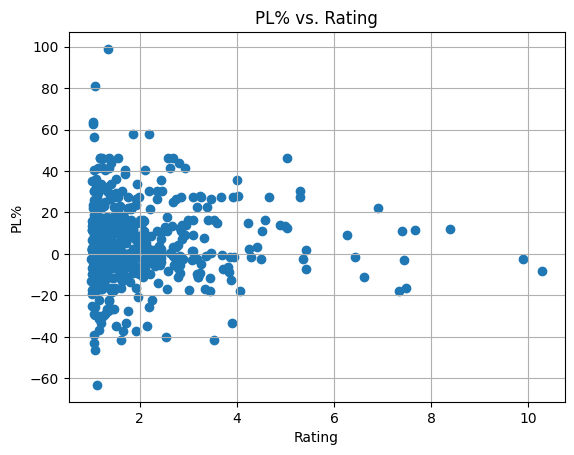

In [22]:
# scatter plot to compare PL% vs Rating for each trade
plt.scatter(all_sims['Rating'], all_sims['PL%'])
plt.xlabel('Rating')
plt.ylabel('PL%')
plt.title('PL% vs. Rating')
plt.grid(True)
plt.show()

In [23]:
all_sims.to_csv('all_sims.csv', index=False)
files.download('all_sims.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# correlation
print(f'Correlation between rating and PL%: {all_sims["Rating"].corr(all_sims["PL%"])}')

Correlation between rating and PL%: 0.02110505703960252


In [25]:
# t-test
# 1) get the baseline ETF return over the same time period from sim_start to end (June 9, 2025)
qqq = yf.download('QQQ', start=sim_start, end=datetime.date(2025,6,10))
etf_performance = round(float(((qqq['Close'].iloc[-1] - qqq['Close'].iloc[0]) / qqq['Close'].iloc[0]).values[0]), 5)
# 2) run the t-test
t_stat, p_val = stats.ttest_1samp(PLs, popmean=etf_performance, alternative='greater')
print("t-statistic:", t_stat)
print("p-value:", p_val)

/tmp/ipython-input-25-1498433146.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq = yf.download('QQQ', start=sim_start, end=datetime.date(2025,6,10))
[*********************100%***********************]  1 of 1 completed

t-statistic: 0.6721774489145267
p-value: 0.25917632867225254
